## Analyze A/B Test Results

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- <a href="#conclusions">Conclusions</a>

<a id='intro'></a>
### Introduction

An e-commerce company has developed a new web page in order to try and increase the number of users who "convert," meaning the number of users who decide to pay for the company's product. Users were divided into two groups, control and treatment. Under the control group, users were given the old web page, and under the treatment group, users were given the new web page. Each user has a unique ID.

<a id='probability'></a>
#### Part I - Probability

Import necessary libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


Use the below cell to find the number of rows in the dataset.

In [3]:
df.shape[0]

294478

The number of unique users in the dataset.

In [4]:
total = df.user_id.nunique()
total

290584

The proportion of users converted.

In [5]:
# assign all rows that converted to 'convert'
convert = df['converted'] == 1

In [6]:
unique_users = df.user_id[convert].nunique()
unique_users

35173

In [7]:
prop_convert = unique_users/total
prop_convert

0.12104245244060237

The number of times the `new_page` and `treatment` don't line up.

In [8]:
# all rows with new_page under landing_page column
new = df['landing_page'] == 'new_page'

# all rows with old_page under landing_page column
old = df['landing_page'] == 'old_page'

# all rows under the control group
control_grp = df['group'] == 'control'

# all rows under the treatment  group
treatment_grp = df['group'] == 'treatment'

In [9]:
# all rows that are not in line with the group and landing page
error = df[((new) & (control_grp)) | ((old) & (treatment_grp))]

Check datastet with missing values.

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.

In [11]:
# Assign new dataset (with the error) removed to variable df2
df2 = df.drop(error.index)

In [12]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

Unique **user_id**s in **df2**.

In [13]:
df2.shape[0]

290585

In [14]:
df2.user_id.nunique()

290584

Check for duplicates.

In [15]:
df2[df2.user_id.duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


Drop duplicate **user_id**.

In [16]:
df2.user_id.drop_duplicates(inplace=True)

The probability of a user that converted regardless of the page received.

In [17]:
# assign all rows in df2 that converted to variable 'convert'
convert = df2.converted == 1

In [18]:
prop_convert = df2[convert].shape[0]/df2.shape[0]
prop_convert

0.11959667567149027

The probability of users who converted under the `control` group.

In [19]:
control_grp = df2['group'] == 'control'

In [20]:
prob_old_page = df2[(control_grp) & (convert)].shape[0]/df2[control_grp].shape[0]
prob_old_page

0.1203863045004612

The probability of users who converted under the `treatment` group.

In [21]:
treatment_grp = df2['group'] == 'treatment'

In [22]:
prob_new_page = df2[(treatment_grp) & (convert)].shape[0]/df2[treatment_grp].shape[0]
prob_new_page

0.11880724790277405

The probability that an individual received the new page.

In [23]:
df2[df2.landing_page == 'new_page'].shape[0]/df2.shape[0]

0.5000636646764286

The difference of the probability of conversion between the new page and the old page.

In [24]:
obs_diff = prob_new_page - prob_old_page
obs_diff

-0.0015790565976871451

#### Findings

<li> Probability of conversion: 0.1196 </li>
<li> Probability of conversion under the control group: 0.1204 </li>
<li> Probability of conversion under the treatment group: 0.1188 </li>
<li> Probability of conversion under the treatment group: 0.1188 </li>
<li> Probability that an individual received the new page: 0.500 </li>
<li> Difference of probability of conversion between the new and old page: -0.0016 </li>
    
>Implementing the new page resulted in a lower conversion probability compared to the old page, given that users had a close to a fair chance (50-50) of landing in the new or old page. However, these results refer to the sample and does not represent the population. Therefore, there is no sufficient evidence that the new page leads to more conversion.

<a id='ab_test'></a>
### Part II - A/B Test

#### Hypothesis:

$$H_0: p_{new} - p_{old} \le 0 $$
$$H_1: p_{new} - p_{old} \gt 0 $$

What is the **convert rate** for $p_{new}$ under the null? 

In [25]:
p_new = df2[df2.converted == 1].shape[0]/df2.shape[0]

# OR simply df2.converted.mean()

p_new

0.11959667567149027

What is the **convert rate** for $p_{old}$ under the null?

In [26]:
p_old = df2[df2.converted == 1].shape[0]/df2.shape[0]

# OR simply df2.converted.mean()

p_old

0.11959667567149027

What is $n_{new}$?

In [27]:
# total number of users under the new page
n_new = df2[df2.landing_page == 'new_page'].shape[0]
n_new

145311

What is $n_{old}$?

In [28]:
# total number of users under the old page
n_old = df2[df2.landing_page == 'old_page'].shape[0]
n_old

145274

Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [29]:
new_page_converted = np.random.choice([0,1], size=n_new, p=[1-p_new, p_new])
new_page_converted.mean()

0.12059651368444234

Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [30]:
old_page_converted = np.random.choice([0,1], size=n_old, p=[1-p_old, p_old])
old_page_converted.mean()

0.11998705893690544

Find $p_{new}$ - $p_{old}$ for the simulated values.

In [31]:
new_page_converted.mean() - old_page_converted.mean()

0.0006094547475369028

Simulate 10,000 $p_{new}$ - $p_{old}$ values and store in an array **p_diffs**.

In [32]:
p_diffs = []
for _ in range(10000):
    new_page_converted = np.random.choice([0,1], n_new, [1-p_new, p_new])
    old_page_converted = np.random.choice([0,1], n_old, [1-p_old, p_old])
    p_diffs.append(new_page_converted.mean() - old_page_converted.mean())

In [33]:
# convert p_diffs to array
p_diffs = np.array(p_diffs)

Plot a histogram of the **p_diffs**

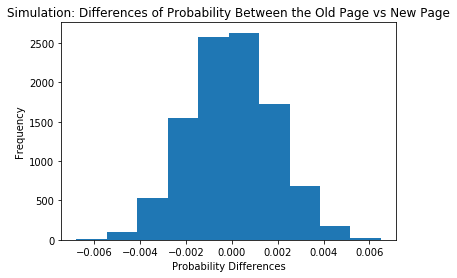

In [34]:
plt.hist(p_diffs)
plt.title('Simulation: Differences of Probability Between the Old Page vs New Page', size = 12)
plt.ylabel('Frequency')
plt.xlabel('Probability Differences');

What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [35]:
(p_diffs > obs_diff).mean()

0.7984

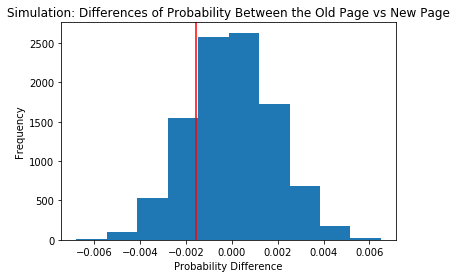

In [36]:
plt.hist(p_diffs)
plt.title('Simulation: Differences of Probability Between the Old Page vs New Page', size = 12)
plt.ylabel('Frequency')
plt.xlabel('Probability Difference');
plt.axvline(obs_diff, color='red');

#### Findings
<li> p-value: </li>

>The variable *p_diffs* contains the mean differences of the conversion rates of the new and old page after simulating each sample with its corresponding sample size and probability equal to its converted rate under the null hypothesis 10,000 times. Then we compare the mean differences with the statistic from the original observation to get the values that are more extreme than the statistic. The result is the **p-value**, which is the probability of observing your statistic if the null is true.

>With a p-value of 0.7984, it is highly likely that the observed statistic is from the null, therefore, the difference of conversion rates between the new and old page does not appear to be significant.

We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [37]:
import statsmodels.api as sm

convert_old = df2[(df2.landing_page == 'old_page') & (df2.converted == 1)].shape[0]
convert_new = df2[(df2.landing_page == 'new_page') & (df2.converted == 1)].shape[0]
n_old = df2[df2.landing_page == 'old_page'].shape[0]
n_new = df2[df2.landing_page == 'new_page'].shape[0]

Use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [38]:
sm.stats.proportions_ztest([convert_new, convert_old],[n_new, n_old], alternative='larger')

(-1.3116075339133115, 0.905173705140591)

#### Findings
<li> z-score: -1.3116 </li>
<li> p-value: 0.905 </li>

>The z-score measures the number of standard deviations away from the observed statistic. For a 95% confidence level in a one-sided distribution, a z-score greater than 1.65 would be considered significant. In this case, the z-score is below the confidence level. The p-value also shows that there is 90.5% probability that the observed statistic comes from the null which is consistent with our previous findings.

<a id='regression'></a>
### Part III - A regression approach

Since we are predicting a categorical variable with two possible outcomes, logistic regression would be the best approach in this case. We need to create dummy variables for each group, which is 1 under the treatment and 0 under the control group. 

The dummy variable for the treatment group will be under the column **ab_page**. 

In [39]:
# Get dummies for the column group. Since we're using the treatment as the explanatory variable, we can drop
# the control column using the drop_first=True argument
df2['ab_page'] = pd.get_dummies(df2['group'], drop_first=True) 

In [40]:
# Quick view of df2 with added dummy variables
df2.head()

,user_id,timestamp,group,landing_page,converted,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0


Fit the model using the **converted** as the response and **ab_page** as the explanatory.

In [41]:
y = df2['converted'] # assign the response variable to y
x1 = df2['ab_page'] # assign the explanatory variable to x1
x = sm.add_constant(x1) # another way of adding intercept without adding a column

# fit the model
log_reg = sm.Logit(y,x)
results = log_reg.fit()

# view statistical output
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212780.6032
Date:               2020-07-08 14:08 BIC:              212801.7625
No. Observations:   290585           Log-Likelihood:   -1.0639e+05
Df Model:           1                LL-Null:          -1.0639e+05
Df Residuals:       290583           LLR p-value:      0.18965    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
const        -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3116  0.1897  -0.0374   0.0074
==================================================================

"""

*In a regression model, we are trying to prove the relationship between the response and explanatory variables. The null hypothesis, therefore, assumes that the coefficient of the explanatory variable is equal to zero, which is a two-tailed test. On the other hand, the process in the previous section involved a one-tailed test, hence the difference in p-values. The hypothesis in this case would be:*

$$H_0: \beta_1 = 0$$
$$H_1: \beta_1 \neq 0$$

*Location, gender, age, product reviews, are just a few things we can consider that may influence whether or not an individual converts. Adding more features can help improve the model, however, there are potential problems that may arise. For logistic regression model, the following assumptions below must stand:*

**Appropriate Outcome Structure**: *Binary logistic regression requires binary dependent variable and ordinal logistic regression requires ordinal dependent variable.*

**Observation Independence**: *Observations in a logistic regression requires to be independent of each other, and should not come from repeated measurements or matched data.*

**No Multicollinearity**: *The independent variables should not be highly correlated with each other.*

**Linearity of Independent Variables and Log Odds**: *Independent variables are linearly related to the log odds.*

**Large Sample Size**: *Logistic regression typically requires a large sample size.*

### Adding `country` as an Additional Explanatory Variable
The country per user is available in a separate dataset. We'll add this to our model to see if it has an impact in conversion.

In [42]:
# Read the countries.csv file and store it under variable countries_df
countries_df = pd.read_csv('./countries.csv')

# Merge the two datasets under user_id and assign it to variable df_new
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')

In [43]:
# Create dummies for each country
df_new[['CA','UK','US']] = pd.get_dummies(df_new['country'])

In [44]:
# Quick view of df_new
df_new.head()

,country,timestamp,group,landing_page,converted,ab_page,CA,UK,US
user_id,,,,,,,,,
630000,US,2017-01-19 06:26:06.548941,treatment,new_page,0,1,0,0,1
630001,US,2017-01-16 03:16:42.560309,treatment,new_page,1,1,0,0,1
630002,US,2017-01-19 19:20:56.438330,control,old_page,0,0,0,0,1
630003,US,2017-01-12 10:09:31.510471,treatment,new_page,0,1,0,0,1
630004,US,2017-01-18 20:23:58.824994,treatment,new_page,0,1,0,0,1


In [45]:
y = df_new['converted'] # assign the converted column as a response variable to y
x = df_new[['ab_page','CA','UK']] # assign the explanatory variables to variable x
x = sm.add_constant(x) # add intercept to x

# fit the model
log_mod = sm.Logit(y,x) 
results = log_mod.fit()

# view the statistical output
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366112
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212781.3782
Date:               2020-07-08 14:08 BIC:              212823.6968
No. Observations:   290585           Log-Likelihood:   -1.0639e+05
Df Model:           3                LL-Null:          -1.0639e+05
Df Residuals:       290581           LLR p-value:      0.17584    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
const        -1.9893    0.0089  -223.7629  0.0000  -2.0067  -1.9718
ab_page      -0.0150    0.0114    -1.3076  0.1910  -0.0374   0.0075
CA           -0.0408    0.0269    -1.5159  0.1296  -0.0934   0.0119
UK            0.0099    0.0133     0.7437  0.4570  -0.0162   0.0359
==================================================================

"""

#### Findings:
<li> ab_page p-value: 0.1910 </li>
<li> CA p-value: 0.1296 </li>
<li> UK p-value: 0.4570 </li>

> Based on the statistical results, all the explanatory variables have p-values greater than $\alpha$ which means there is no signifact relationship between the response variable (*converted*) and explanatory variables (*new web page, countries*). Therefore, we fail to reject the null hypothesis. 

### Add interaction between page and country

In [46]:
# compute for the interaction between the page and countries
df_new['CA_page'] = df_new['ab_page'] * df_new['CA']
df_new['UK_page'] = df_new['ab_page'] * df_new['UK']

In [47]:
# quick view of df_new with added columns
df_new.head()

,country,timestamp,group,landing_page,converted,ab_page,CA,UK,US,CA_page,UK_page
user_id,,,,,,,,,,,
630000,US,2017-01-19 06:26:06.548941,treatment,new_page,0,1,0,0,1,0,0
630001,US,2017-01-16 03:16:42.560309,treatment,new_page,1,1,0,0,1,0,0
630002,US,2017-01-19 19:20:56.438330,control,old_page,0,0,0,0,1,0,0
630003,US,2017-01-12 10:09:31.510471,treatment,new_page,0,1,0,0,1,0,0
630004,US,2017-01-18 20:23:58.824994,treatment,new_page,0,1,0,0,1,0,0


In [48]:
y = df_new['converted'] # assign the converted column as a response variable to y
x = df_new[['ab_page','CA','UK', 'CA_page', 'UK_page']] # assign the explanatory variables to variable x
x = sm.add_constant(x) # add intercept to x

# fit the model
log_mod = sm.Logit(y,x)
results = log_mod.fit()

# view the the statistical output
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366108
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212782.9124
Date:               2020-07-08 14:08 BIC:              212846.3903
No. Observations:   290585           Log-Likelihood:   -1.0639e+05
Df Model:           5                LL-Null:          -1.0639e+05
Df Residuals:       290579           LLR p-value:      0.19182    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
const        -1.9865    0.0096  -206.3440  0.0000  -2.0053  -1.9676
ab_page      -0.0206    0.0137    -1.5060  0.1321  -0.0474   0.0062
CA           -0.0175    0.0377    -0.4652  0.6418  -0.0914   0.0563
UK           -0.0057    0.0188    -0.3057  0.7598  -0.0426   0.0311
CA_page      -0.0469    0.0538    -0.8716  0.3834  -0.1523   0.0585
UK_page       0.0314    0.0266     1.1811  0.2375  -0.0207   0.0835
==================================================================

"""

#### Findings:
> The p-values of all explanatory variables are still greater than $\alpha$ and are not significant even with the interaction between page and countries added to the model. There is no sufficient evidence the new page, countries, and interaction of page and countries, have a relationship with conversion, therefore, we fail to reject the null hypothesis.

<a id='conclusions'></a>
## Conclusions

After a series of tests and statistical analysis of the A/B Test results, there were no significant evidences that the new page increased the number of users who converted. However, the test was conducted for only less than a month. In doing so, a number of factors were not accounted for, such as user behavioral change. Longer duration of tests is highly recommended in this case. 

## References
<li> https://www.statisticssolutions.com/assumptions-of-logistic-regression/ </li>
<li> https://csrgxtu.github.io/2015/03/20/Writing-Mathematic-Fomulars-in-Markdown/ </li>